In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import gym
import torch
import torch.nn as nn

from env.p2p_elec_market_3 import TradingSession as TradingSession3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Price dynamics:

In [5]:
prices = {}

env = TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus')
env.reset()
done = False

prices[3] = np.array(env.session_prices)

while done == False:
    _, _, done, _ = env.step(0)
    prices[3] = np.vstack([prices[3], env.session_prices])

C:\123\thesis\p2p_DQN\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


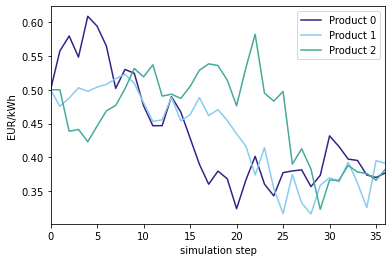

In [10]:
plt.style.use(['C:/Users/lub/.matplotlib/stylelib/muted.mplstyle',              
               'C:/Users/lub/.matplotlib/stylelib/no-latex.mplstyle'])

#fig, ax = plt.subplots(1, figsize = [6,3])
fig, ax = plt.subplots(1)

ax.plot(prices[3]/100)
ax.set_xlim([0, len(prices[3]) - 1])
ax.set_ylabel('EUR/kWh')
ax.set_xlabel('simulation step')
ax.legend(['Product 0', 'Product 1', 'Product 2'])
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('prices.pdf', bbox_inches='tight')

# Training curves

In [11]:
sims = ['runs/Jun22_16-38-24_WIN10-LUB/reward_100.csv', 
        'runs/Jun22_16-38-27_WIN10-LUB/reward_100.csv', 
        'runs/Jun22_16-38-32_WIN10-LUB/reward_100.csv']

DQN = {}

for sim in sims:
    DQN[sim] = pd.read_csv(sim)

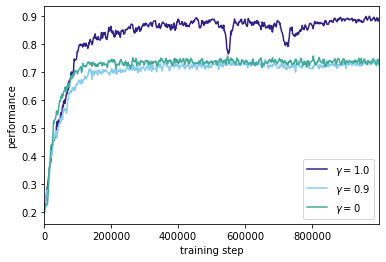

In [12]:
#fig, axs = plt.subplots(1, figsize = [6,3])
fig, axs = plt.subplots(1)

for i, p in enumerate(sims):
    axs.plot(DQN[p].values[:,1], DQN[p].values[:,2])

axs.set_xlim([0, DQN[p].values[-1,1]])
axs.set_ylabel('performance')
axs.set_xlabel('training step')
axs.legend([r'$\gamma = 1.0$', r'$\gamma = 0.9$', r'$\gamma = 0$'])
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('train.pdf',bbox_inches='tight')

# Testing the models

In [13]:
class DQN(nn.Module):
    """Deep Q-network with target network"""

    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        # network
        self.fc = nn.Sequential(
                    nn.Linear(n_inputs, 64),
                    nn.ReLU(),
                    nn.Linear(64, 64),
                    nn.ReLU(),
                    nn.Linear(64, n_outputs)
        )


    def forward(self, x):
        x = x.float()
        return self.fc(x)

In [14]:
class BaselinePolicy:
    """
    Policy that selects action based in current environment state.
    If holdings_quantity does not exceed the boundary, place order with constant value in session with min price.
    If holdings_quantity exceeds the boundary, do not place any order.
    Inputs:
        - current_state: dictionary with current state of the environment
        - constant_order: constant value of the order whem holdings_quantity do not exceed the boundary
        - boundary: boundary of the environment
    """
    def __init__(self, mode, boundary, constant_order=1, action_space_config='discrete'):
        self.constant_order = constant_order
        self.boundary = boundary
        self.mode = mode
        self.action_space_config = action_space_config

    def select_action(self, env):
        self.session_prices = env.session_prices
        self.holdings_quantity = env.holdings_quantity

        if np.sum(self.holdings_quantity) + env.constant_order > self.boundary:
            if self.action_space_config == 'continous':
                action = np.zeros(len(self.holdings_quantity))
                return action
            elif self.action_space_config == 'discrete':
                return np.array([2*len(self.session_prices)])

        else:
            if self.mode == 'min_price':
                idx_min_price = np.argmin(self.session_prices)
                if self.action_space_config == 'continous':
                    action[idx_min_price] = self.constant_order
                    return action
                elif self.action_space_config == 'discrete':
                    return np.array([idx_min_price])

            elif self.mode == 'random':
                idx_random = np.random.randint(0,len(self.session_prices)-1)
                if self.action_space_config == 'continous':
                    action[idx_random] = self.constant_order
                    return action
                elif self.action_space_config == 'discrete':
                    return np.array([idx_random])


# Config and seeds:

In [15]:
num_episodes = 1000
seeds = np.random.randint(num_episodes*2, size=num_episodes)
nums_mutual_sessions = [3]
perf = {}
envs = [TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus')]

sims = ['random-{}'.format(i) for i in range(len(envs))] + ['min_price-{}'.format(i) for i in range(len(envs))] + ['0_gamma-{}'.format(i) for i in range(len(envs))] + ['09_gamma-{}'.format(i) for i in range(len(envs))]+ ['1_gamma-{}'.format(i) for i in range(len(envs))]
obs_dict = dict.fromkeys(sims)
actions_dict = dict.fromkeys(sims)
returns_dict = dict.fromkeys(sims)
q_values_dict = dict.fromkeys(sims)

C:\123\thesis\p2p_DQN\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Random baseline

In [16]:
mode = 'random'
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs
    policy = BaselinePolicy(mode = mode, boundary = env.boundary, action_space_config = 'discrete')
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        obs = env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            action = policy.select_action(env)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
        policy_reward = np.add.accumulate(rewards)[-1]
        returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], policy_reward])
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("{} performance: {}%". format(mode, round(100*avg_per, 2)))

random performance: 30.45%


# Min price

In [17]:
mode = 'min_price'
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs
    policy = BaselinePolicy(mode = mode, boundary = env.boundary, action_space_config = 'discrete')
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            action = policy.select_action(env)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
        policy_reward = np.add.accumulate(rewards)[-1]
        returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], policy_reward])
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("{} performance: {}%". format(mode, round(100*avg_per, 2)))

min_price performance: 72.93%


# gamma = 0

In [18]:
mode = '0_gamma'
model_path = ['runs\Jun22_16-38-32_WIN10-LUB\model_0_part_1.dat']
    
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs    
    net = DQN(env.observation_space.shape[0], env.action_space.n)
    net.load_state_dict(torch.load(model_path[i], map_location=lambda storage, loc: storage))
    
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        obs = env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            state_v = torch.tensor(np.array([obs], copy=False))
            q_vals = net(state_v).data.numpy()[0]
            q_values_dict[mode + '-{}'.format(i)] = np.vstack([q_values_dict[mode + '-{}'.format(i)], q_vals.max()])
            action = np.argmax(q_vals)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
            returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], reward])
        policy_reward = np.add.accumulate(rewards)[-1]
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("0_gamma-{} performance: {}%". format(i, round(100*avg_per, 2)))

0_gamma-0 performance: 73.99%


# gamma = 0.9

In [19]:
mode = '09_gamma'
model_path = ['runs\Jun22_16-38-27_WIN10-LUB\model_09_part_1.dat']
    
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs    
    net = DQN(env.observation_space.shape[0], env.action_space.n)
    net.load_state_dict(torch.load(model_path[i], map_location=lambda storage, loc: storage))
    
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        obs = env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            state_v = torch.tensor(np.array([obs], copy=False))
            q_vals = net(state_v).data.numpy()[0]
            q_values_dict[mode + '-{}'.format(i)] = np.vstack([q_values_dict[mode + '-{}'.format(i)], q_vals.max()])
            action = np.argmax(q_vals)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
            returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], reward])
        policy_reward = np.add.accumulate(rewards)[-1]
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("09_gamma-{} performance: {}%". format(i, round(100*avg_per, 2)))

09_gamma-0 performance: 72.94%


# gamma = 1

In [20]:
mode = '1_gamma'
model_path = ['runs\Jun22_16-38-24_WIN10-LUB\model_1_part_1.dat']
    
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs    
    net = DQN(env.observation_space.shape[0], env.action_space.n)
    net.load_state_dict(torch.load(model_path[i], map_location=lambda storage, loc: storage))
    
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        obs = env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            state_v = torch.tensor(np.array([obs], copy=False))
            q_vals = net(state_v).data.numpy()[0]
            q_values_dict[mode + '-{}'.format(i)] = np.vstack([q_values_dict[mode + '-{}'.format(i)], q_vals.max()])
            action = np.argmax(q_vals)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
            returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], reward])
        policy_reward = np.add.accumulate(rewards)[-1]
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("1_gamma-{} performance: {}%". format(i, round(100*avg_per, 2)))

1_gamma-0 performance: 89.0%


# Performances

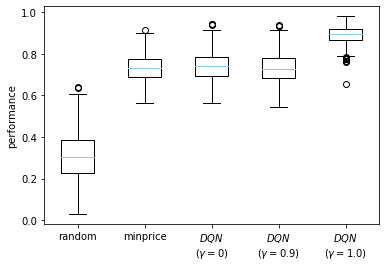

In [34]:
#fig, axs = plt.subplots(1, figsize = [6,3])
fig, axs = plt.subplots(1)

axs.boxplot(np.vstack([perf['random-0'], perf['min_price-0'], perf['0_gamma-0'], perf['09_gamma-0'], perf['1_gamma-0']]).T)
axs.set_ylabel('performance')
axs.set_xticklabels(['random', 'minprice', r'$DQN$''\n''$(\gamma = 0)$', r'$DQN$''\n''$(\gamma = 0.9)$', r'$DQN$''\n''$(\gamma = 1.0)$'])
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('performance.pdf', bbox_inches='tight')

# Prices analysis

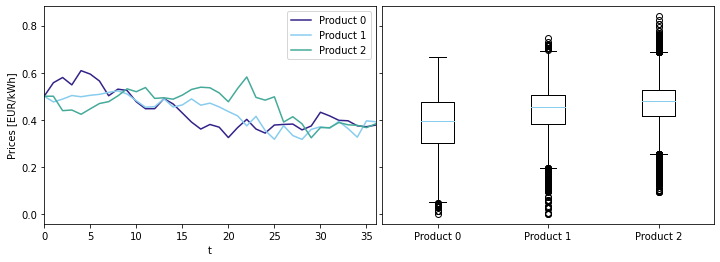

In [51]:
fig, axs = plt.subplots(1, 2, figsize = [12,4], sharey = True)
#fig, axs = plt.subplots(1, 2, sharey = True)

axs[0].plot(prices[3]/100)
axs[0].set_xlim([0, len(prices[3]) - 1])
axs[0].set_ylabel('Prices [EUR/kWh]')
axs[0].set_xlabel('t')
axs[0].legend(['Product {}'.format(i) for i in range(0, 3)])

axs[1].boxplot(obs_dict['random-0'][:,0:3])
axs[1].set_ylim()
axs[1].set_xticklabels(['Product {}'.format(i) for i in range(0, 3)])

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('prices.pdf', bbox_inches='tight')

# Q-Value function

In [29]:
fut_return = {}
exp_fut_return = {}
rel_error = {}

fut_return['0_gamma-0'] = np.cumsum(returns_dict['0_gamma-0'][returns_dict['0_gamma-0'] != np.array(None)].reshape([1000,36]).T, axis=0)[-1,:] - np.cumsum(returns_dict['0_gamma-0'][returns_dict['0_gamma-0'] != np.array(None)].reshape([1000,36]).T, axis=0)
fut_return['09_gamma-0'] = np.cumsum(returns_dict['09_gamma-0'][returns_dict['09_gamma-0'] != np.array(None)].reshape([1000,36]).T, axis=0)[-1,:] - np.cumsum(returns_dict['09_gamma-0'][returns_dict['09_gamma-0'] != np.array(None)].reshape([1000,36]).T, axis=0)
fut_return['1_gamma-0'] = np.cumsum(returns_dict['1_gamma-0'][returns_dict['1_gamma-0'] != np.array(None)].reshape([1000,36]).T, axis=0)[-1,:] - np.cumsum(returns_dict['1_gamma-0'][returns_dict['1_gamma-0'] != np.array(None)].reshape([1000,36]).T, axis=0)
exp_fut_return['0_gamma-0'] = q_values_dict['0_gamma-0'][q_values_dict['0_gamma-0'] != np.array(None)].reshape(1000,36).T
exp_fut_return['09_gamma-0'] = q_values_dict['09_gamma-0'][q_values_dict['09_gamma-0'] != np.array(None)].reshape(1000,36).T
exp_fut_return['1_gamma-0'] = q_values_dict['1_gamma-0'][q_values_dict['1_gamma-0'] != np.array(None)].reshape(1000,36).T

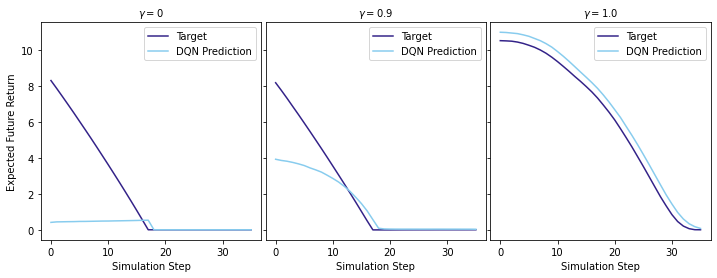

In [30]:
fig, axs = plt.subplots(1, 3, figsize = [12,4], sharey = True, sharex = True)

axs[0].plot(np.mean(fut_return['0_gamma-0'], axis=1))
axs[0].plot(np.mean(exp_fut_return['0_gamma-0'], axis=1))
axs[1].plot(np.mean(fut_return['09_gamma-0'], axis=1))
axs[1].plot(np.mean(exp_fut_return['09_gamma-0'], axis=1))
axs[2].plot(np.mean(fut_return['1_gamma-0'], axis=1))
axs[2].plot(np.mean(exp_fut_return['1_gamma-0'], axis=1))

axs[0].set_title(r'$\gamma = 0$', size= 'medium')
axs[1].set_title(r'$\gamma = 0.9$', size= 'medium')
axs[2].set_title(r'$\gamma = 1.0$', size= 'medium')

axs[0].set_ylabel('Expected Future Return', size= 'medium')

axs[0].set_xlabel('Simulation Step', size= 'medium')
axs[1].set_xlabel('Simulation Step', size= 'medium')
axs[2].set_xlabel('Simulation Step', size= 'medium')

axs[0].legend(['Target', 'DQN Prediction'], loc = 'upper right')
axs[1].legend(['Target', 'DQN Prediction'], loc = 'upper right')
axs[2].legend(['Target', 'DQN Prediction'], loc = 'upper right')

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('predictions.pdf', bbox_inches='tight')

# Visualizing policy

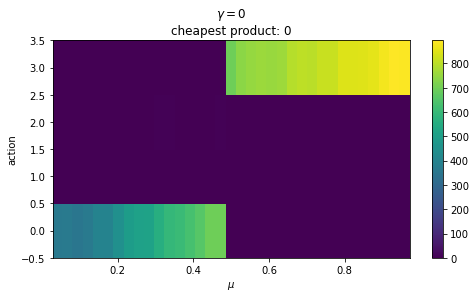

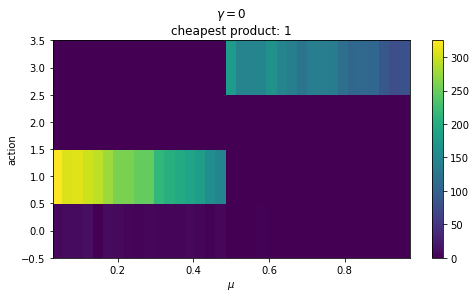

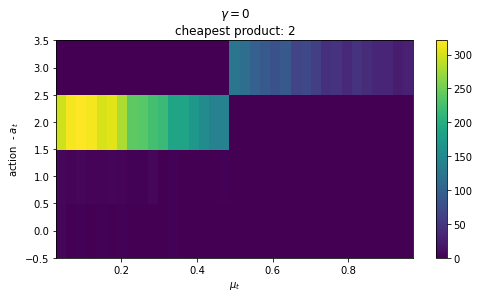

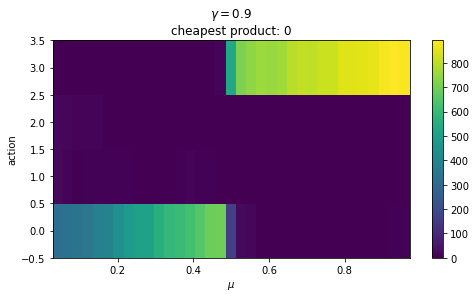

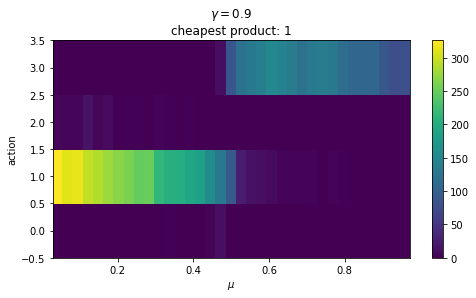

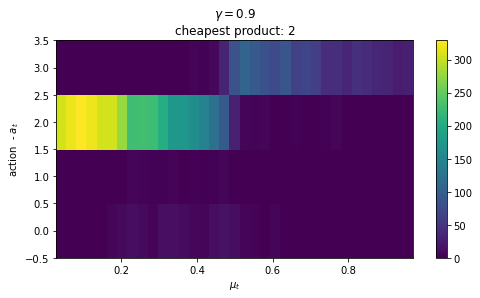

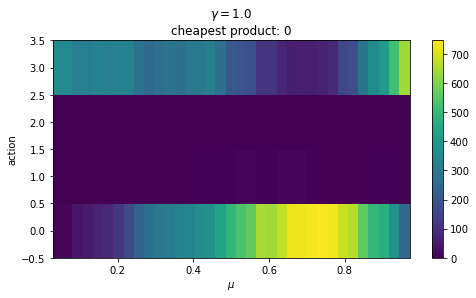

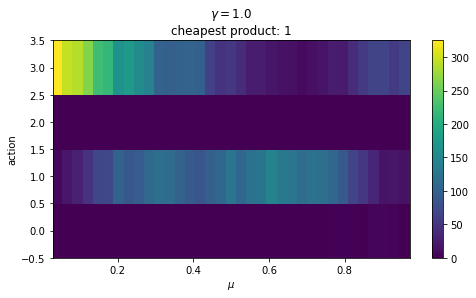

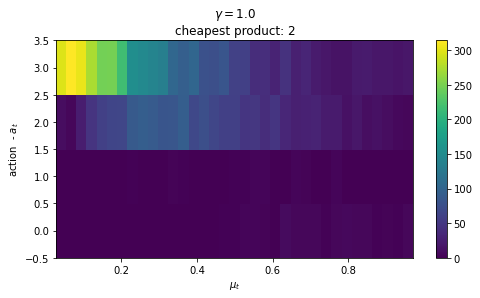

In [53]:
gammas = ['0_gamma-0', '09_gamma-0', '1_gamma-0']
g = ['0', '0.9', '1.0']

for g, gamma in zip(g, gammas):
    policy_df = pd.DataFrame(np.hstack([obs_dict[gamma][1:,:],actions_dict[gamma][1:,:]]))
    p0_df = policy_df[(policy_df.iloc[:,0] < policy_df.iloc[:,1]) & (policy_df.iloc[:,0] < policy_df.iloc[:,2])]
    p1_df = policy_df[(policy_df.iloc[:,1] < policy_df.iloc[:,0]) & (policy_df.iloc[:,1] < policy_df.iloc[:,2])]
    p2_df = policy_df[(policy_df.iloc[:,2] < policy_df.iloc[:,1]) & (policy_df.iloc[:,2] < policy_df.iloc[:,0])]
    
    #Getting data
    x=p0_df.iloc[:,4]
    y=p0_df.iloc[:,5]

    # Creating figure
    fig, ax = plt.subplots(1, figsize =(8, 4))

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    plt.hist2d(x, y, bins =[x_bins, y_bins]) 
    plt.colorbar()

    ax.set_title(r'$\gamma = {}$'.format(g) + '\ncheapest product: 0')
    ax.set_ylabel('action')  
    ax.set_xlabel(r'$\mu$')
    
    plt.savefig('pol_prod0_{}.pdf'.format(g), bbox_inches='tight')
    
    #Getting data
    x=p1_df.iloc[:,4]
    y=p1_df.iloc[:,5]

    # Creating figure
    fig, ax = plt.subplots(1, figsize =(8, 4))

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    plt.hist2d(x, y, bins =[x_bins, y_bins]) 
    plt.colorbar()

    ax.set_title(r'$\gamma = {}$'.format(g) + '\ncheapest product: 1')
    ax.set_ylabel('action')  
    ax.set_xlabel(r'$\mu$')

    plt.savefig('pol_prod1_{}.pdf'.format(g), bbox_inches='tight')
    
    #Getting data
    x=p2_df.iloc[:,4]
    y=p2_df.iloc[:,5]

    # Creating figure
    fig, ax = plt.subplots(1, figsize =(8, 4))

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    plt.hist2d(x, y, bins =[x_bins, y_bins]) 
    plt.colorbar()

    ax.set_title(r'$\gamma = {}$'.format(g) + '\ncheapest product: 2')
    ax.set_ylabel(r'action  - $a_t$')  
    ax.set_xlabel(r'$\mu_t$')
    
    plt.savefig('pol_prod2_{}.pdf'.format(g), bbox_inches='tight')   

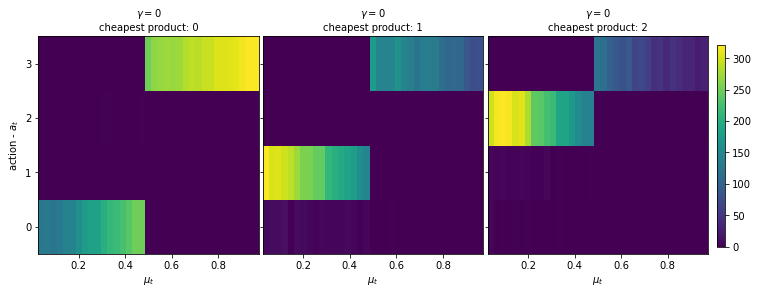

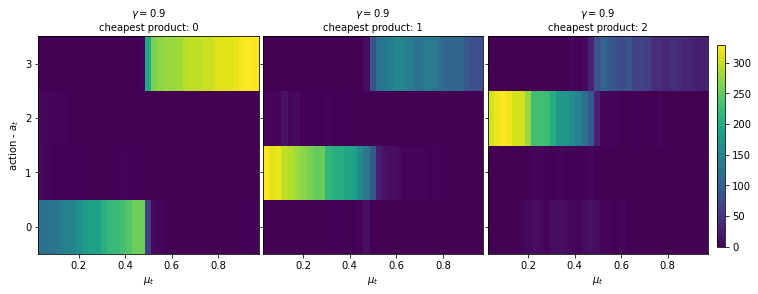

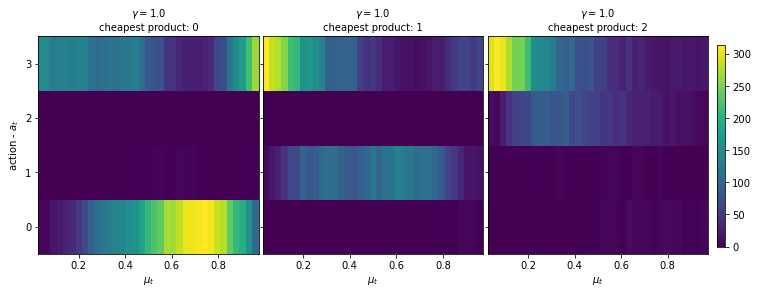

In [54]:
gammas = ['0_gamma-0', '09_gamma-0', '1_gamma-0']
g = ['0', '0.9', '1.0']

for g, gamma in zip(g, gammas):
    policy_df = pd.DataFrame(np.hstack([obs_dict[gamma][1:,:],actions_dict[gamma][1:,:]]))
    p0_df = policy_df[(policy_df.iloc[:,0] < policy_df.iloc[:,1]) & (policy_df.iloc[:,0] < policy_df.iloc[:,2])]
    p1_df = policy_df[(policy_df.iloc[:,1] < policy_df.iloc[:,0]) & (policy_df.iloc[:,1] < policy_df.iloc[:,2])]
    p2_df = policy_df[(policy_df.iloc[:,2] < policy_df.iloc[:,1]) & (policy_df.iloc[:,2] < policy_df.iloc[:,0])]
    
    #Getting data
    x=p0_df.iloc[:,4]
    y=p0_df.iloc[:,5]

    # Creating figure
    fig, axs = plt.subplots(1, 3, figsize =(12, 4), sharey = True, sharex = True)

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    axs[0].hist2d(x, y, bins =[x_bins, y_bins]) 

    axs[0].set_title(r'$\gamma = {}$'.format(g) + '\ncheapest product: 0', size = 'medium')
    axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_xlabel(r'$\mu_t$')
    axs[0].set_ylabel(r'action - $a_t$')
        
    #Getting data
    x=p1_df.iloc[:,4]
    y=p1_df.iloc[:,5]

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    axs[1].hist2d(x, y, bins =[x_bins, y_bins]) 

    axs[1].set_title(r'$\gamma = {}$'.format(g) + '\ncheapest product: 1', size = 'medium')
    axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].set_xlabel(r'$\mu_t$')
    
    #Getting data
    x=p2_df.iloc[:,4]
    y=p2_df.iloc[:,5]

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    h = axs[2].hist2d(x, y, bins =[x_bins, y_bins]) 
    axs[2].set_title(r'$\gamma = {}$'.format(g) + '\ncheapest product: 2', size = 'medium')
    axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[2].set_xlabel(r'$\mu_t$')
    
    cbaxes = fig.add_axes([0.91, 0.15, 0.01, 0.7]) 
    #cbar = fig.colorbar(h[3], ax=axs[:], cax = cbaxes, ticks=[0, 165, 330])
    #cbar.ax.set_yticklabels(['low', 'medium', 'high'])
    cbar = fig.colorbar(h[3], ax=axs[:], cax = cbaxes)
    
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.savefig('policy_{}.pdf'.format(g), bbox_inches='tight')   